In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
color_pallet = sns.color_palette()
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [23]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [24]:
# checking first few rows of train df
train_df.head()

,Date,store,product,number_sold
0,2010-01-01,0,0,801
1,2010-01-02,0,0,810
2,2010-01-03,0,0,818
3,2010-01-04,0,0,796
4,2010-01-05,0,0,808


In [25]:
# checking first few rows of test df
test_df.head()

,Date,store,product,number_sold
0,2019-01-01,0,0,845
1,2019-01-02,0,0,851
2,2019-01-03,0,0,840
3,2019-01-04,0,0,842
4,2019-01-05,0,0,845


In [26]:
# checking info of our train df
train_df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230090 entries, 0 to 230089
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Date         230090 non-null  object
 1   store        230090 non-null  int64 
 2   product      230090 non-null  int64 
 3   number_sold  230090 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.0+ MB


In [27]:
train_df.describe()

,store,product,number_sold
count,230090.000000,230090.000000,230090.000000
mean,3.000000,4.500000,780.926107
std,2.000004,2.872288,204.096737
min,0.000000,0.000000,238.000000
25%,1.000000,2.000000,722.000000
50%,3.000000,4.500000,835.000000
75%,5.000000,7.000000,914.000000
max,6.000000,9.000000,1205.000000


### we can see the type of date column is object type,lets change it to correct type

In [28]:
train_df['Date'] = pd.to_datetime(train_df['Date'])
## changing column name from numbers_sold to sold
new_columns = ['Date','Store','Products','Sold']
train_df.columns = new_columns
test_df.columns = new_columns

In [29]:
# different types of stores available inour dataframe
train_df['Store'].value_counts()

0    32870
1    32870
2    32870
3    32870
4    32870
5    32870
6    32870
Name: Store, dtype: int64

In [30]:
# Different types of products available inour dataframe
train_df['Products'].value_counts()

0    23009
1    23009
2    23009
3    23009
4    23009
5    23009
6    23009
7    23009
8    23009
9    23009
Name: Products, dtype: int64

### We will deal with each store individually

## Store 1

In [31]:
train_df.set_index('Date', inplace= True)

In [32]:
train_df.head()

,Store,Products,Sold
Date,,,
2010-01-01,0,0,801
2010-01-02,0,0,810
2010-01-03,0,0,818
2010-01-04,0,0,796
2010-01-05,0,0,808


### 1st product

In [35]:
## Store with product id 0
s1p1 =train_df[(train_df['Store']==0) & (train_df['Products']==0)]
s1p1.head()

,Store,Products,Sold
Date,,,
2010-01-01,0,0,801
2010-01-02,0,0,810
2010-01-03,0,0,818
2010-01-04,0,0,796
2010-01-05,0,0,808


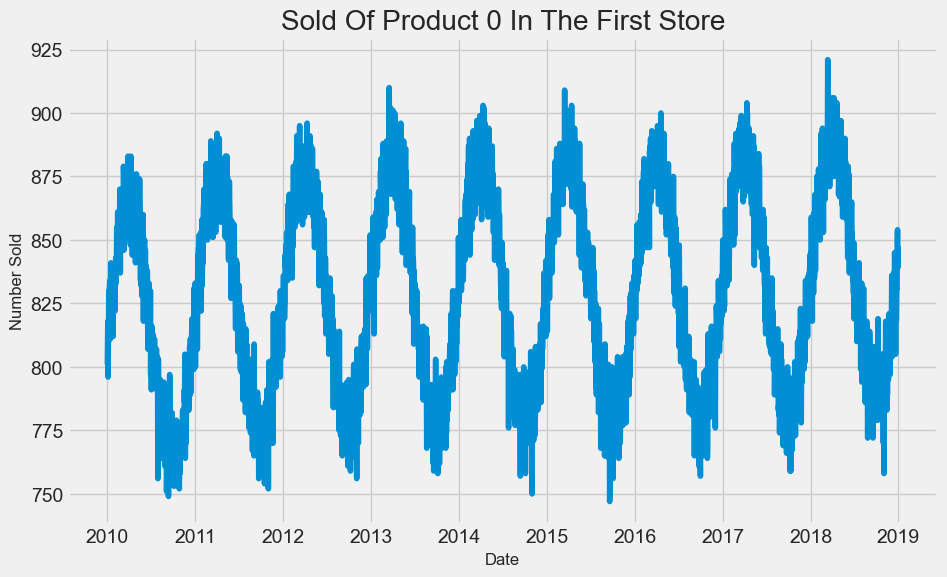

In [40]:
plt.figure(figsize = (10, 6))
plt.plot(s1p1.index, s1p1['Sold'])
plt.xlabel('Date', {'fontsize': 12})
plt.ylabel('Number Sold', {'fontsize': 12})
plt.title('Sold Of Product 0 In The First Store')
plt.show()
       

#### Analysis

From the above graph as we can see , sale of products '0' have been very stationary in the given time period.

### Ways to check if the given data is Stationery

### We can check whether a given time series is stationery or not using 2 tests , namely

1. Rolling Statistics

2. Augumented Dickey Fuller Test

### Rolling Statistics

This is more of a visual test

Here , we simply plot the moving average or variance of the given time series and try to observe if the plotted varies a lot with time

If average and variance do not change much with time , then our time series is stationery

In [45]:
average = s1p1['Sold'].dropna().rolling(window = 12).mean() #Rolling Average year
std = s1p1['Sold'].dropna().rolling(window = 12).std() #Rolling Standard Deviation

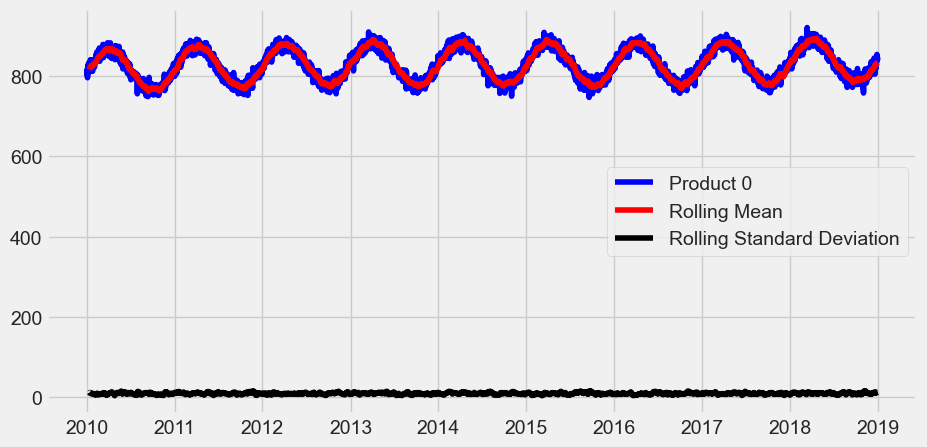

In [48]:
plt.figure(figsize = (10 , 5))
plt.plot(s1p1.index, s1p1['Sold'],c = 'b',label='Product 0')
plt.plot(average , c = 'r' , label = 'Rolling Mean' )
plt.plot(std , c = 'black' , label = 'Rolling Standard Deviation')
plt.legend()

#### It is clearly observable from the above Test that the given time series data is close to being stationary


### Let us scientifically confirm our above claim by using the famous Augumented Dickey Fuller Test

Augumented Dickey Fuller Test (ADF)

Let us assume a NULL Hypothesis H0 that the given time series is not stationary

Check the test statistic and values for different confidence intervals

If test statistic is < alpha value, reject the H0

Here , we take our confidence interval to be 95%